In [1]:
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys


def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))

'''my Tmodel(considering gas (SI))'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*sciconsts.G)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)*np.power(sciconsts.G,2.0)/np.power(sciconsts.c,4.0)/10.0/mpc
'''my Tmode not considering gas'''
def acalvac(t,k_1,t_c):
    return np.power(4*k_1*(t_c-t),0.25)
def freq_tvac(t,m_1,m_2,t_c):
    avt=acalvac(t,k_1cal(m_1,m_2),t_c)
    return np.sqrt(sciconsts.G*(m_1+m_2))/sciconsts.pi*np.power(avt,-1.5)
def phi_tvac(t,m_1,m_2,t_c):
    cm2=chirp_mass(m_1,m_2)
    return -2*np.power(np.power(sciconsts.c,3.0)/5.0/cm2/sciconsts.G*(t_c-t),5.0/8.0)
def hvac(t,m_1,m_2,t_c,phi_c):
    return  m_1*m_2/acalvac(t,k_1cal(m_1,m_2),t_c)*np.cos(phi_tvac(t,m_1,m_2,t_c)+phi_c)/1e70
#phi_c[0,2pi]
def f_jugg(t_c,m_1,m_2):
    return (freq_tvac(0,m_1,m_2,t_c),freq_tvac(4*years,m_1,m_2,t_c))
def t_fvac(f,m_c,t_c):
    sci1=np.power(sciconsts.c,3.0)/5.0/m_c/sciconsts.G
    return t_c-np.power(8.0*sciconsts.pi*f/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0)
def tlimit(m_c,fi,ff):
    sci1=np.power(sciconsts.c,3.0)/5.0/m_c/sciconsts.G
    a=np.array((np.power(8.0*sciconsts.pi*fi/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0),4*years+np.power(8.0*sciconsts.pi*ff/5.0,-8.0/3.0)*np.power(sci1,5.0/3.0)))
    return [a.min(),a.max()]
def tcn_decide(mc,fi,ff,acu):
    return ((tlimit(mc,fi,ff)[1]-tlimit(mc,figas,ffgas)[0])/tlimit(mc,fi,ff)[1])//acu+1
def noden_cal(mc,phinum,tcn_racu,fi,ff):
    mcn=mc.size
    i=0
    sum1=0
    while i<mcn:
        sum1=sum1+tcn_decide(mc[i],fi,ff,tcn_racu)
        i=i+1
    return sum1*phinum


def pow2(a):
    b=1
    i=True
    while i:
        b=2*b
        if b>a:
            i=False
    return b
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)
fname=sys.argv[0]+'value.txt'
#consts setting
m_sun=1.9891e30
years=365*24*3600.0
mpc=3.261*sciconsts.light_year*1e6
t_scale=4*years
#gas cal
m_1g=10*m_sun
m_2g=10*m_sun
k_1g=k_1cal(m_1g,m_2g)
t_gas=100000.0*years
a_0=3.0e8
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)
#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=10000000
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
tphi=np.linspace(0,t_scale,10000)
i=0
workphi=np.zeros(10000)
while i<10000:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)
A=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.005)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
Aval

3.0260976242453375e-08

In [48]:
k=500.0
nk=Ng/k
t=t_scale/k
d_f=k/t_scale
print d_f,nk
f0=np.linspace(0,Ng/2.0/t_scale,num=nk//2)
i=0
ti=0
tf=nk-1
hf0=np.zeros(nk//2)
while i<k-1:
    hf0=hf0+2.0/nk*abs(fft.fft(hfgas[ti:tf]))[0:nk//2]
    ti=ti+nk
    tf=tf+nk
    i=i+1

3.96372399797e-06 20000.0


/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


In [45]:
k=1000.0
nk=Ng/k
t=t_scale/k
d_f=k/t_scale
print d_f,nk
f1=np.linspace(0,Ng/2.0/t_scale,num=nk//2)
i=0
ti=0
tf=nk-1
hf1=np.zeros(nk//2)
while i<k-1:
    hf1=hf1+2.0/nk*abs(fft.fft(hfgas[ti:tf]))[0:nk//2]
    ti=ti+nk
    tf=tf+nk
    i=i+1

7.92744799594e-06 10000.0


/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


In [64]:
k=2000000.0
nk=Ng/k
t=t_scale/k
d_f=k/t_scale
print d_f,nk
f2=np.linspace(0,Ng/2.0/t_scale,num=nk//2)
i=0
ti=0
tf=nk-1
hf2=np.zeros(nk//2)
while i<k-1:
    hf2=hf2+2.0/nk*abs(fft.fft(hfgas[ti:tf]))[0:nk//2]
    ti=ti+nk
    tf=tf+nk
    i=i+1

0.0158548959919 5.0


/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


array([  1.70481984e-24,   1.70487888e-24,   1.70502238e-24, ...,
         2.14949873e-25,   2.14949825e-25,   2.14949801e-25])

In [3]:
np.where(hfgas2>=0.95*hfgas2.max())

(array([398211, 398212, 398213, 398214, 398215, 398216, 398217, 398218,
        398219, 398220, 398221, 398222, 398223, 398224, 398225, 398226,
        400753, 400754, 400755, 400756, 400757, 400758, 400759, 400760,
        400761, 400762, 400763, 400764, 400765, 400766, 400767, 400768,
        400769]),)

In [8]:
import matplotlib.pyplot as plt
import pywt as pw

In [79]:
k=1000000.0
nk=Ng/k
t=t_scale/k
d_f=k/t_scale
print d_f,nk
f2=np.linspace(0,Ng/2.0/t_scale,num=nk//2)
i=0
ti=0
tf=nk-1
hf2=np.zeros(nk//2)
while i<k-1:
    hf2=hf2+2.0/nk*abs(fft.fft(hfgas[ti:tf]))[0:nk//2]
    ti=ti+nk
    tf=tf+nk
    i=i+1
hfwin=sci_interpolate.interp1d(f2,hf2)
4*np.sqrt(sci_integrate.quad(lambda x:4*np.power(hfwin(x),2.0)/S_n_lisa(x),0.003,ffgas,limit=1500,epsabs=0.005))

0.00792744799594 10.0


/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


array([  1.21967593e+01,   1.28513741e-06])

In [67]:
1e6 1 12.19 2 29.10

array([  7.27725547e+00,   7.66783459e-07])

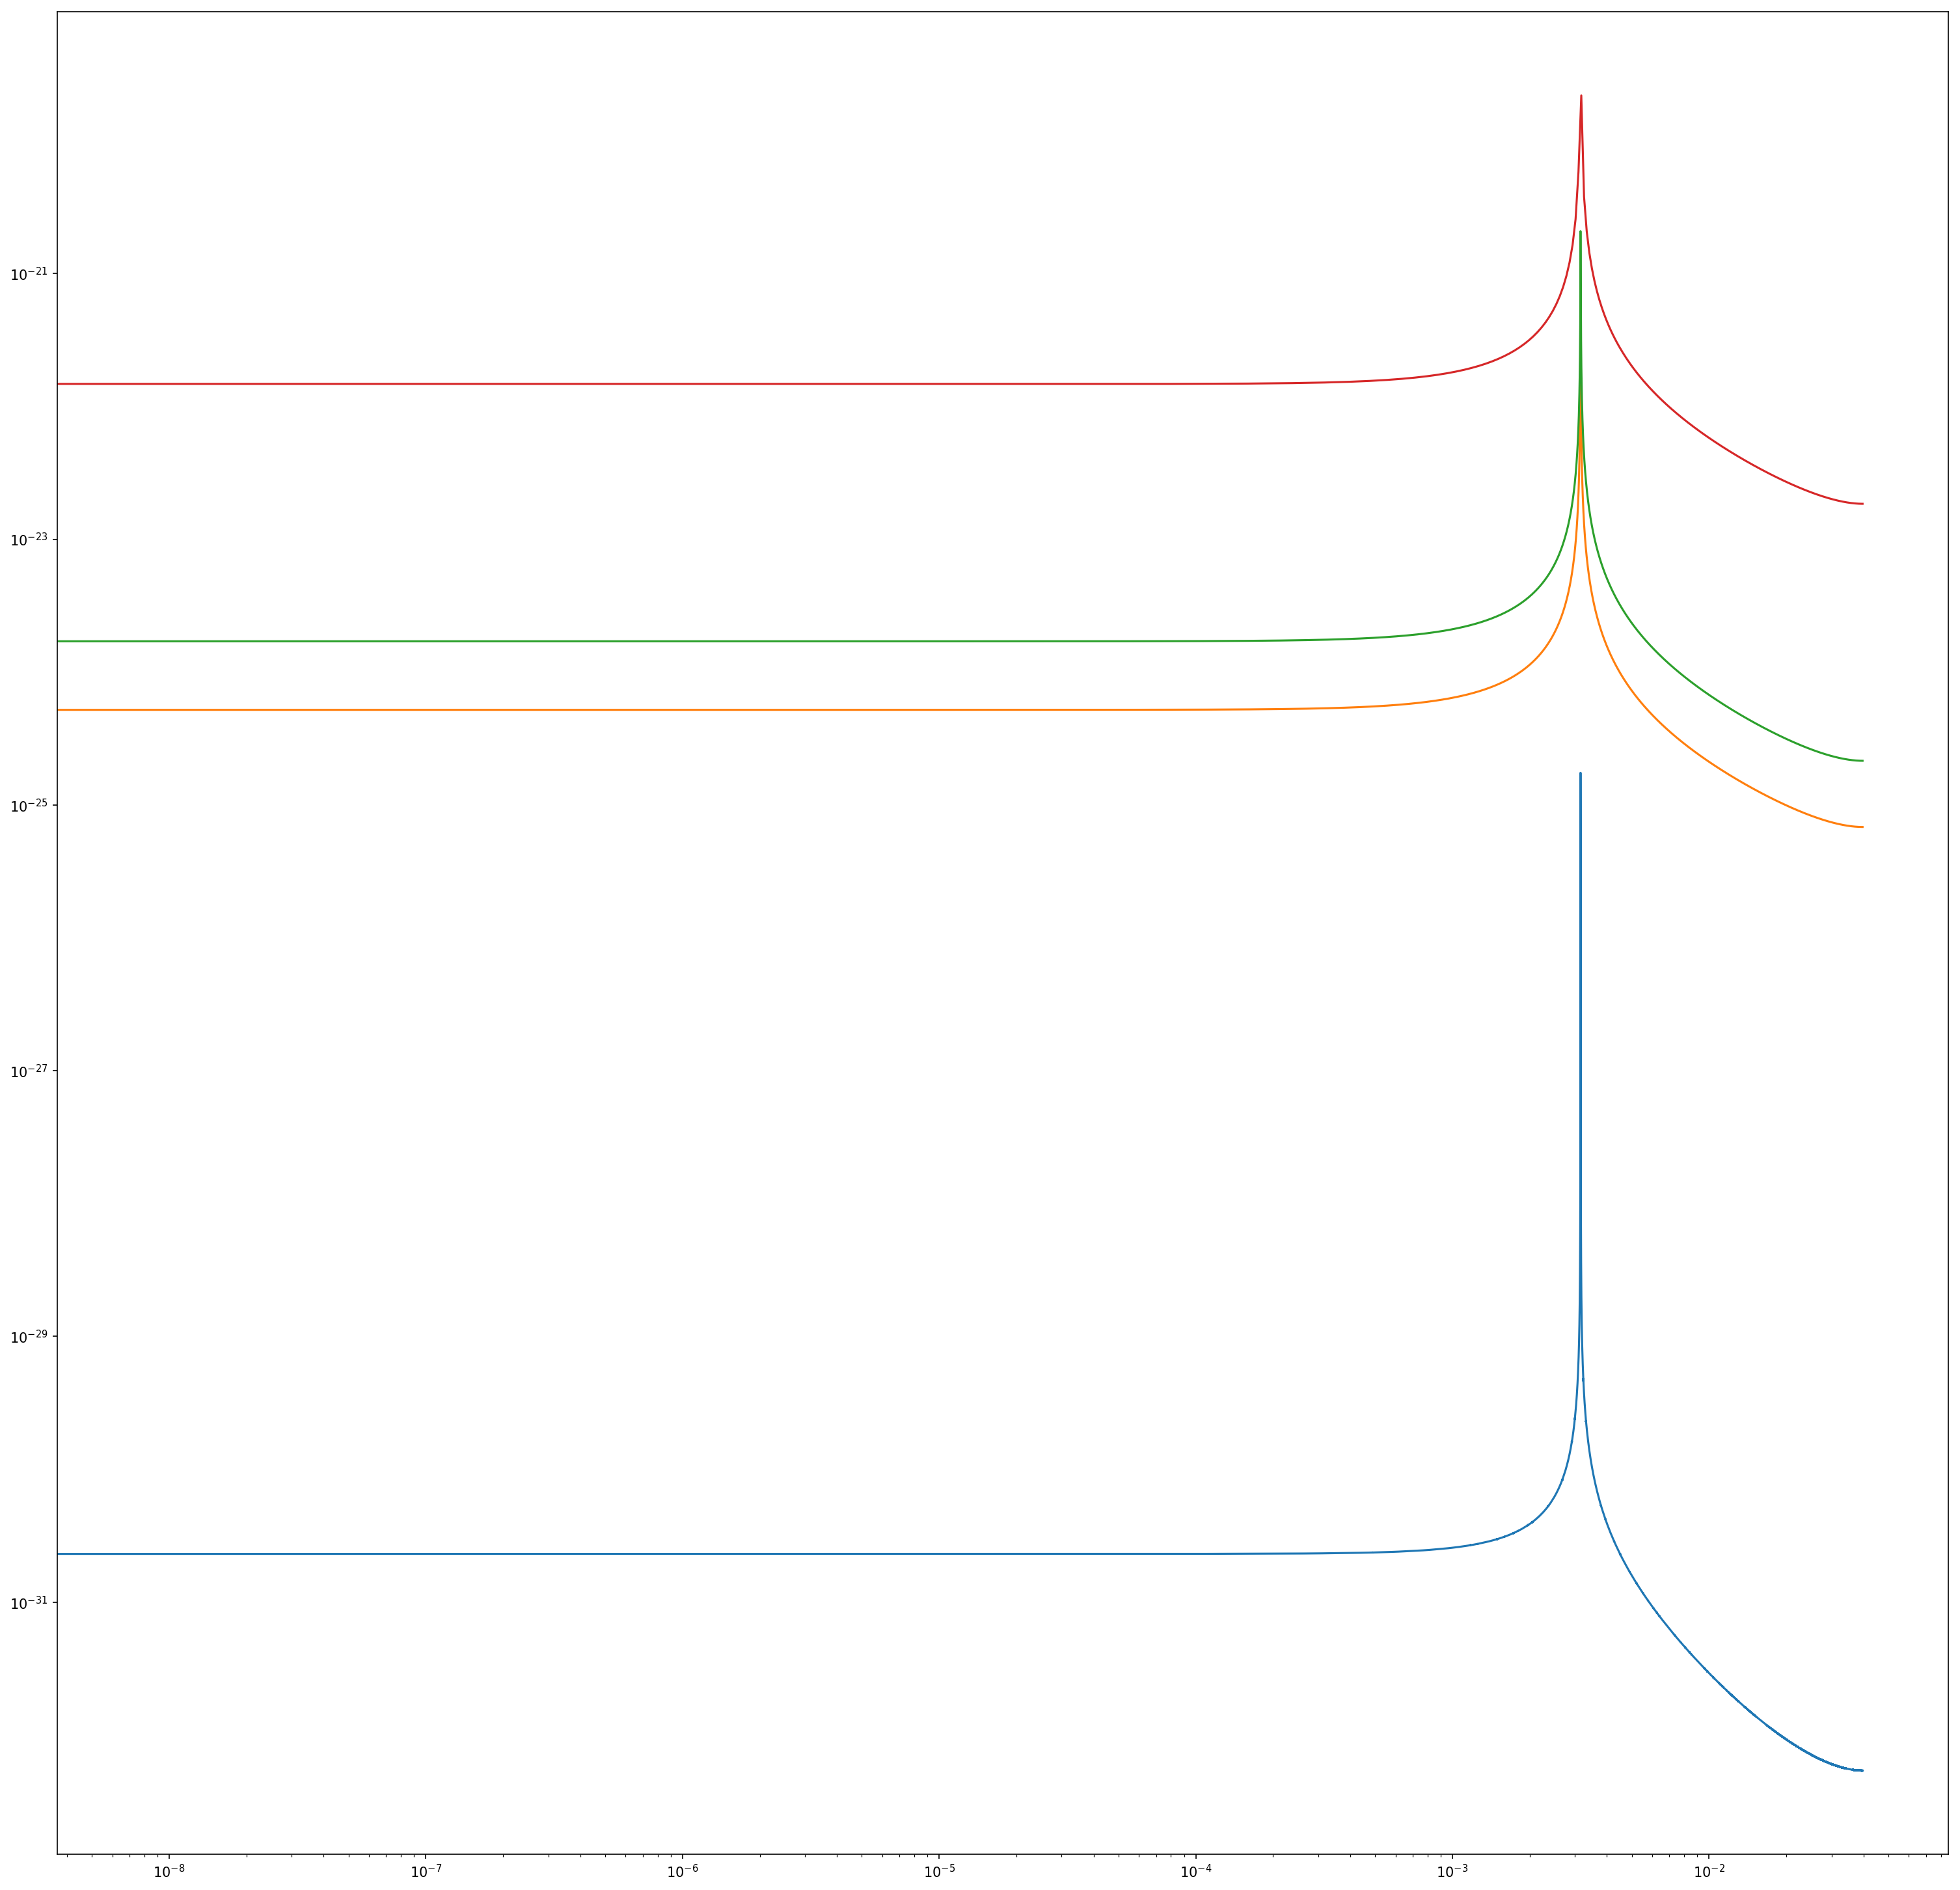

In [51]:
fig1=plt.figure(figsize=(25,25),dpi=150)
plt.plot(xs,hfgas2)
plt.plot(f0,hf0)
plt.plot(f1,hf1)
plt.plot(f2,hf2)
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0.003,0.0032)
plt.show()

In [6]:
hi=m_1g*m_1g*4/a_0/10/mpc*np.power(sciconsts.G,2.0)/np.power(sciconsts.c,4.0)

In [40]:
np.sqrt(hi*hi*0.5*4*years*4/1.902*1e40)

10.859743002109907

In [17]:
sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),0.0001,0.01,limit=1500,epsabs=0.005)

(2.6115238401125523e-22, 3.877439995087168e-22)

In [9]:
fint=np.linspace(0.0001,0.01,10000)
sns=np.zeros(10000)
i=0
while i<10000:
    sns[i]=S_n_lisa(fint[i])
    i=i+1

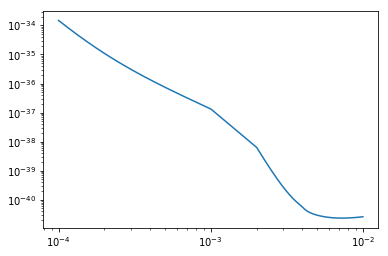

In [8]:
plt.plot(fint,sns)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
sn=sci_interpolate.interp1d(fint,sns,)

In [38]:
sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.005)

(9.503706137235434e-16, 4.777458120228238e-17)

In [ ]:
sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/sn(x),figas,ffgas,limit=1500,epsabs=0.005)

10.859743002109907

In [ ]:
#parameters changes
mcnum=1000
phinum=50
acu=0.00005
mcs=np.linspace(37.2842105*m_sun,37.210526*m_sun,mcnum)
phis=np.linspace(0,2*sciconsts.pi,phinum)
data=np.zeros((mcnum,3))
noden=noden_cal(mcs,phinum,0.0001,figas,ffgas)
print 'cal start,node=',noden,' esiT=',noden/3600.0*10,'h'
sys.stdout.flush()
mcn=0
pn=0.0
tb=time.clock()
while mcn<mcnum:
    ffmax=0.0
    errmax=0.0
    m1v=solvem(mcs[mcn],0.25)[0]
    m2v=solvem(mcs[mcn],0.25)[1]
    tcl=tlimit(mcs[mcn],figas,ffgas)
    tcnum=tcn_decide(mcs[mcn],figas,ffgas,acu)
    tcl_sp=np.linspace(tcl[0],tcl[1],tcnum)
    tcn=0
    while tcn<tcnum:
        phin=0
        while phin<phinum:
            ti=time.clock()
            fivac=freq_tvac(0,m1v,m2v,tcl_sp[tcn])
            ffvac=freq_tvac(4*years,m1v,m2v,tcl_sp[tcn])
            Ng=int(t_scale*ffvac*4)
            Ng=pow2(Ng)
            T=t_scale/Ng
            xs=np.linspace(0,1/2.0/T,num=Ng//2)
            t=np.linspace(0,t_scale,num=Ng//2)
            hvt=hvac(t,m1v,m2v,tcl_sp[tcn],phis[phin])
            hfvac1=fft.fft(hvt)
            hfvac_abs=abs(hfvac1)
            hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
            anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
            hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
            hvacs=sci_interpolate.interp1d(xs,hfvac2)
            d=(np.array((fivac,figas)).max(),np.array((ffvac,ffgas)).min())
            B=sci_integrate.quad(lambda x:4*np.power(hvacs(x),2.0)/S_n_lisa(x),fivac,ffvac,limit=1500,epsabs=0.005)
            Bval=np.sqrt(B[0])
            Berr=0.5/Bval*B[1]
            AB=sci_integrate.quad(lambda x:4*hvacs(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)),d[0],d[1],limit=1500,epsabs=0.005)
            ff=AB[0]/Aval/Bval
            err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)
            tf=time.clock()
            if ff>ffmax:
                ffmax=ff
                errmax=err
            #print pn,round(tf-ti,2),ff,err
            #sys.stdout.flush()
            phin=phin+1
            pn=pn+1
        tcn=tcn+1
    data[mcn,0]=mcs[mcn]/m_sun
    data[mcn,1]=ffmax
    data[mcn,2]=errmax
    print data[mcn,0],data[mcn,1],data[mcn,2]
    sys.stdout.flush()
    mcn=mcn+1
np.savetxt(fname,data)
te=time.clock()
print 'cal completed!',(te-tb)/3600,'h'
sys.stdout.flush()

